<a href="https://colab.research.google.com/github/Dulyaaa/Deep_Learning/blob/main/GAN/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.78MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 12.6MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.69MB/s]
  0%|          | 0/469 [00:00<?, ?it/s]

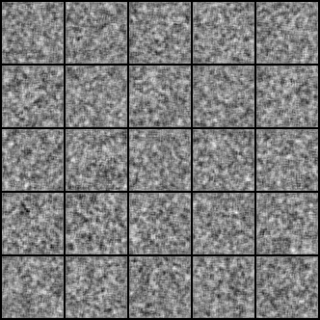


 11%|█         | 50/469 [14:37<2:00:17, 17.23s/it]

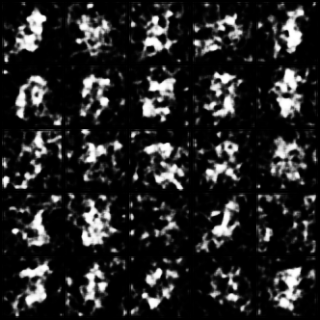


 21%|██▏       | 100/469 [29:27<1:46:23, 17.30s/it]

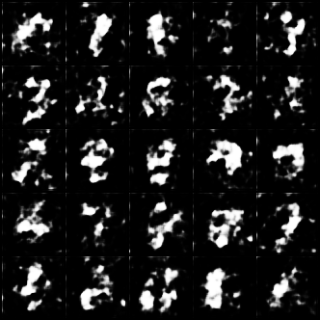


 32%|███▏      | 150/469 [43:55<1:33:38, 17.61s/it]

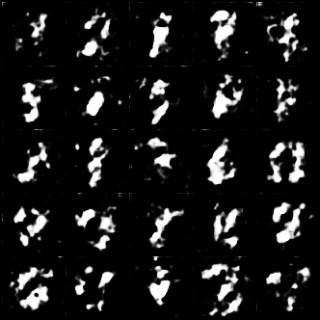


 43%|████▎     | 200/469 [58:25<1:17:41, 17.33s/it]

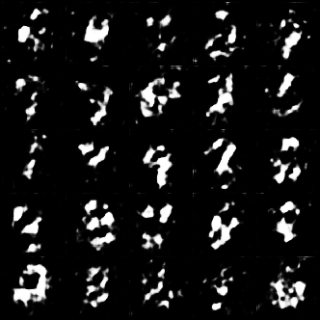


 53%|█████▎    | 250/469 [1:12:53<1:02:53, 17.23s/it]

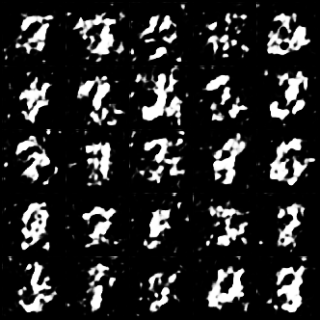


 64%|██████▍   | 300/469 [1:27:21<48:28, 17.21s/it]

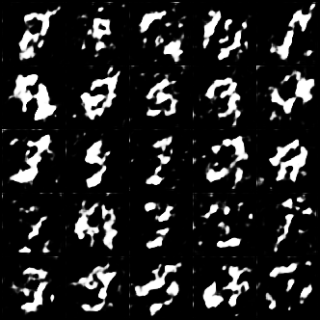


 75%|███████▍  | 350/469 [1:41:52<34:38, 17.47s/it]

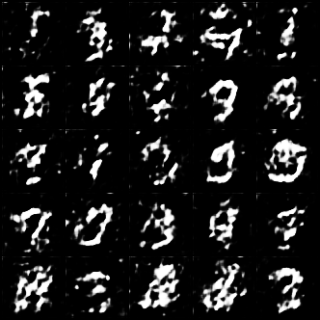


 85%|████████▌ | 400/469 [1:56:22<20:10, 17.55s/it]

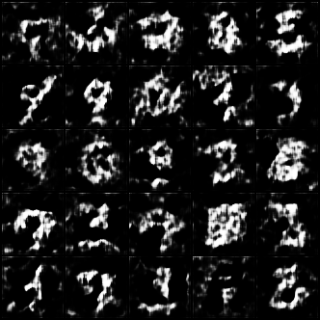


 96%|█████████▌| 450/469 [2:10:51<05:29, 17.34s/it]

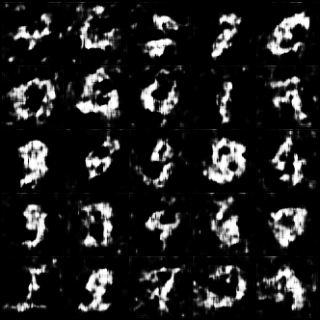


  7%|▋         | 31/469 [09:01<2:05:36, 17.21s/it]

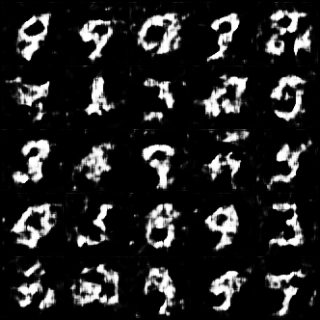


 17%|█▋        | 81/469 [23:40<1:51:42, 17.27s/it]

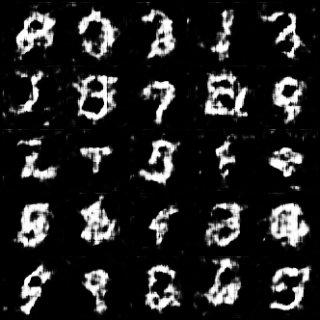


 28%|██▊       | 131/469 [38:13<1:38:54, 17.56s/it]

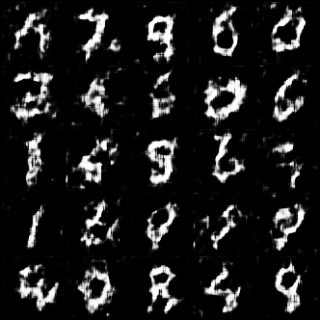


 39%|███▊      | 181/469 [52:43<1:22:21, 17.16s/it]

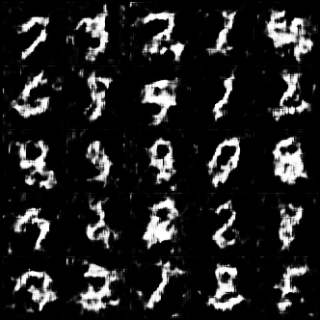


 49%|████▉     | 231/469 [1:07:15<1:07:40, 17.06s/it]

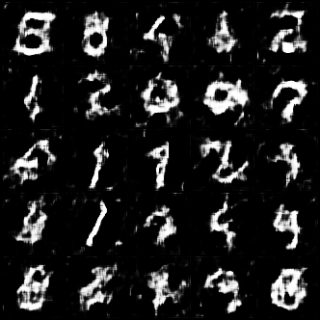


 60%|█████▉    | 281/469 [1:22:10<55:09, 17.61s/it]

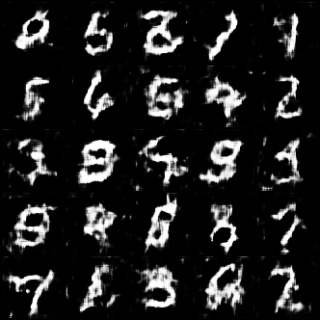


 71%|███████   | 331/469 [1:36:52<39:34, 17.20s/it]

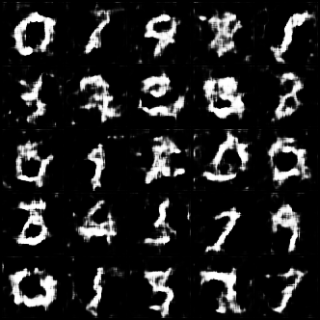


 81%|████████  | 379/469 [1:51:08<26:24, 17.60s/it]

In [ ]:
import argparse
import logging
import os
from time import strftime

import torch
from numpy import random
from torch import FloatTensor, cuda, nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import transforms
from torchvision.utils import save_image
from tqdm import tqdm

import cv2
from google.colab.patches import cv2_imshow

# Define logger
logger = logging.getLogger(name="DCGAN")


class Generator(nn.Module):
    """
    Generator: Model takes noise as input and generates a 2D image as output,
    latent_dim: the size of noise data taken as input.
    img_shape: shape of output image.
    """
    def __init__(self, latent_dim, img_shape):
        super(Generator, self).__init__()

        img_size, channels = img_shape[1], img_shape[0]
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size**2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.l1(x)
        x = x.view(x.shape[0], 128, self.init_size, self.init_size)
        x = self.conv_blocks(x)
        return x


class Discriminator(nn.Module):
    """
    Discriminator: Model takes real images from training data and fake images by Generator and tries seperate them.
    img_shape: Input image shape.d
    """
    def __init__(self, img_shape):
        super(Discriminator, self).__init__()

        img_size, channels = img_shape[1], img_shape[0]

        def discriminator_block(in_filters, out_filters, normalize=True):
            block = [
                nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.25),
            ]
            if normalize:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(channels, 16, normalize=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
            *discriminator_block(128, 512)
        )

        ds_size = img_size // 2**4
        self.output_layer = nn.Sequential(
            nn.Linear(128 * ds_size**2, 1), nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_blocks(x)
        x = x.view(x.shape[0], -1)
        x = self.output_layer(x)

        return x


def get_data(root, img_size, batch_size):
    """Returns MNIST dataset as a dataloader"""
    logger.info(
        f"Initializing MNIST data as a dataloader with batch size of {batch_size}"
    )
    os.makedirs(root, exist_ok=True)
    train_data = DataLoader(
        datasets.MNIST(
            root=root,
            train=True,
            download=True,
            transform=transforms.Compose(
                [
                    transforms.Resize(img_size),
                    transforms.ToTensor(),
                    transforms.Normalize([0.5], [0.5]),
                ]
            ),
        ),
        batch_size=batch_size,
        shuffle=True,
    )
    logger.info(f"Data loader created and stored in {root}")

    return train_data


def get_loss():
    """Returns Binary cross-entropy as loss."""
    logger.info("Initializing Binary Cross Entropy Loss for training.")
    return nn.BCELoss()


def get_device():
    "Returns CUDA if cuda supporitng GPU available for use, else CPU."
    return "cuda" if cuda.is_available() else "cpu"


def get_optimizer(model, lr, b1, b2):
    """Returns Adam optimizer."""
    logger.info(
        f"Initializing Adam Optimizer with Learning rate of {lr} and first and second order momentum as {b1} and {b2} respectively."
    )
    return Adam(model.parameters(), lr=lr, betas=(b1, b2))


def generate_noise(noise_shape, Tensor):
    """Returns noise tensor."""
    return Variable(Tensor(random.normal(0, 1, noise_shape)))


def weights_init_normal(m):
    """Applies random normal weight initialisation for models."""
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0.0)


def main(
    root,
    img_dir,
    latent_dim,
    img_shape,
    batch_size,
    lr,
    b1,
    b2,
    n_epochs,
    sampling_interval,
    model_dir
):
    """Defines the model and performs training."""
    writer = SummaryWriter(log_dir=f".logs/dcgan/{strftime('%d%m%Y_%H%M%S')}")
    logger.info("Tensorboard initialization completed, please launch to track results.")

    img_size, channels = img_shape[1], img_shape[0]
    logger.info(f"Image Size: {img_size} | Image Channels: {channels}")

    data_loader = get_data(root, img_size, batch_size)

    device = get_device()
    logger.info(f"Available device for training: {device}")

    example_input, _ = next(iter(data_loader))

    generator = Generator(latent_dim, img_shape)
    p_count = sum(p.numel() for p in generator.parameters() if p.requires_grad)
    logger.info(f"Generator Model Initialized, total trainable parameters: {p_count}")
    writer.add_graph(
        generator, generate_noise((example_input.shape[0], latent_dim), FloatTensor)
    )

    discriminator = Discriminator(img_shape)
    p_count = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
    logger.info(
        f"Discriminator Model Initialized, total trainable parameters: {p_count}"
    )

    writer.add_graph(discriminator, example_input)
    logger.info("Model graph wirtten to tensorboard")

    loss = get_loss()

    if device == "cuda":
        generator.cuda()
        discriminator.cuda()
        loss.cuda()
        logger.info("Model and Loss loaded to GPU")

    generator.apply(weights_init_normal)
    discriminator.apply(weights_init_normal)
    logger.info("Weights are initialized with normal distribution function.")

    g_optim = get_optimizer(generator, lr, b1, b2)
    d_optim = get_optimizer(discriminator, lr, b1, b2)

    Tensor = cuda.FloatTensor if device == "cuda" else FloatTensor
    os.makedirs(img_dir, exist_ok=True)

    batch_size = len(data_loader)
    curr_min_g_loss = float("inf")
    curr_min_d_loss = float("inf")
    os.makedirs(model_dir, exist_ok=True)

    for epoch in tqdm(range(n_epochs)):
        mean_g_loss, mean_d_loss = 0, 0
        logger.info(f"Epoch: {epoch}")
        for batch, (imgs, _) in enumerate(tqdm(data_loader)):

            # Define labels
            real = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
            fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)

            # Setup input
            real_imgs = Variable(imgs.type(Tensor))

            # Train Generator
            g_optim.zero_grad()

            # Generate noise
            z = generate_noise((imgs.shape[0], latent_dim), Tensor)

            gen_imgs = generator(z)

            g_loss = loss(discriminator(gen_imgs), real)

            g_loss.backward()
            g_optim.step()

            mean_g_loss += g_loss.item()

            # Train Discriminator
            d_optim.zero_grad()

            real_loss = loss(discriminator(real_imgs), real)
            fake_loss = loss(discriminator(gen_imgs.detach()), fake)

            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            d_optim.step()

            mean_d_loss += d_loss.item()
            if d_loss.item() < curr_min_d_loss:
                curr_min_d_loss = d_loss.item()
                torch.save(discriminator, os.path.join(model_dir, "discriminator.pt"))

            curr_iter = (epoch * batch_size) + batch

            if curr_iter % sampling_interval == 0:
                writer.add_scalar("Generator Loss", g_loss.item(), curr_iter)
                writer.add_scalar("Discriminator Loss", d_loss.item(), curr_iter)
                logger.info(
                    f"Iteration: {curr_iter}/{n_epochs*batch_size} | G-Loss: {g_loss.item()} | D-Loss: {d_loss.item()}"
                )
                save_image(
                    gen_imgs.data[:25],
                    os.path.join(img_dir, f"{curr_iter}.png"),
                    nrow=5,
                    normalize=True,
                )
                img_to_show = cv2.imread(os.path.join(img_dir, f"{curr_iter}.png"), 1)
                img_to_show = cv2.resize(
                    img_to_show, (1 * 5 * img_size, 1 * 5 * img_size)
                )
                cv2_imshow(img_to_show)
                # cv2.waitKey(10) # Removed as cv2_imshow does not require this.

        mean_g_loss, mean_d_loss = mean_g_loss / batch_size, mean_d_loss / batch_size
        logger.info(
            f"\nMean Generator Loss: {mean_g_loss} \nMean Discriminator: {mean_d_loss}"
        )
        if mean_g_loss > curr_min_g_loss:
            curr_min_g_loss = mean_g_loss
            torch.save(generator, os.path.join(model_dir, "generator.pt"))
            logger.info("Generator Model checkpoint saved.")

        if mean_d_loss < curr_min_d_loss:
            curr_min_d_loss = curr_min_d_loss
            torch.save(discriminator, os.path.join(model_dir, "discriminator.pt"))
            logger.info("Discrimator Model checkpoint saved.")

    # cv2.destroyAllWindows() # Removed as cv2_imshow does not require this.


if __name__ == "__main__":
    parser = argparse.ArgumentParser()
    try:
        parser.add_argument(
            "--root",
            type=str,
            default=os.path.join(".", ".data", "input", "mnist"),
            help="location to store data.",
        )
        parser.add_argument(
            "--img_dir",
            type=str,
            default=os.path.join(".", ".data", "output", "mnist"),
            help="Location to store generated images.",
        )
        parser.add_argument(
            "--latent_dim", type=int, default=500, help="size of noise vector."
        )
        parser.add_argument(
            "--img_shape",
            type=tuple,
            default=(1, 64, 64),
            help="Shape of training and generated images",
        )
        parser.add_argument(
            "--batch_size", type=int, default=128, help="Mini batch size for training."
        )
        parser.add_argument(
            "--lr", type=float, default=0.0002, help="Learning rate for training."
        )
        parser.add_argument(
            "--b1",
            type=float,
            default=0.5,
            help="Adam optimizer: decay of first order momentum.",
        )
        parser.add_argument(
            "--b2",
            type=float,
            default=0.999,
            help="Adam optimizer: decay of second order momentum.",
        )
        parser.add_argument(
            "--n_epochs", type=int, default=200, help="number of epochs of training"
        )
        parser.add_argument(
            "--sampling_interval",
            type=int,
            default=50,
            help="How often to take sample of generator output.",
        )
        parser.add_argument(
            "--log_dir",
            type=str,
            default=".logs/mnist/",
            help="Location to store logs.",
        )
        parser.add_argument(
            "--model_dir",
            type=str,
            default=".model/mnist/",
            help="Location to store models.",
        )
    except argparse.ArgumentError:
        logger.error("Argument Error Occured.")
        logger.error(parser.print_help())
        parser.print_help()

    args = parser.parse_args([])
    root = args.root
    img_dir = args.img_dir
    latent_dim = args.latent_dim
    img_shape = args.img_shape
    batch_size = args.batch_size
    lr = args.lr
    b1 = args.b1
    b2 = args.b2
    n_epochs = args.n_epochs
    sampling_interval = args.sampling_interval
    model_dir = args.model_dir

    os.makedirs(args.log_dir, exist_ok=True)
    log_file = os.path.join(args.log_dir, "training.log")
    logging.basicConfig(
        level=logging.INFO,
        filename=log_file,
        filemode="w",
        format="%(name)s - %(levelname)s - %(message)s",
    )

    main(
        root=root,
        img_dir=img_dir,
        latent_dim=latent_dim,
        img_shape=img_shape,
        batch_size=batch_size,
        lr=lr,
        b1=b1,
        b2=b2,
        n_epochs=n_epochs,
        sampling_interval=sampling_interval,
        model_dir=model_dir,
    )